In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (15,9)

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import NMF
from pathlib import Path

from analysis import analysis # this works because same package
from utils import utils, files # sibling package...


# protocol

1. record calibration dataset and extract per-channel variances
2. do PCA on the variance-scaled calibration dataset in order for PCs to not be contaminated by channel scales and choose PCs to make a linear decoder
3. in the center-hold-reach-out task, scale each incoming EMG channel by its calibration variance
4. project center-hold samples onto decoder PCs (and subsequently filter)

TODO:

- add scaling to bonsai for center-hold task
  - pick up scaling array from python / subject folder `variance.bin`
  - this is a diagonal matrix `np.diag(vars)`

NOTES:

- variances in natural movement task are not always similar to that of the calibration, so we opt not to scale the calibration task by the natural movement task
- one option to deal with "loud" channels is to keep a running variance and scale this way

In [2]:
def build_experiment_path_dict(experiment):
    data_folder = get_experiment_data_folder(experiment)
    subjects = [x.name for x in data_folder.iterdir() if x.name[0] != "."]
    path_dictionary = {"subjects":{}}
    for subject in subjects:
        subject_folder = data_folder / subject
        path_dictionary["subjects"].update({subject:{}})
        path_dictionary["subjects"][subject].update({"path" : subject_folder})
        tasks = [x.name for x in subject_folder.iterdir() if x.name[0] != "."]
        path_dictionary["subjects"][subject].update({"tasks": {}})
        for task in tasks:
            path_dictionary["subjects"][subject]["tasks"].update({task : {"path" : subject_folder/task}})
            session_paths = sorted([x for x in (subject_folder/task).iterdir() if x.name[0] != "."],key=lambda x:x.name[-1])
            session_names = [x.name for x in session_paths]
            path_dictionary["subjects"][subject]["tasks"][task].update({"sessions": {}})
            for path, session in zip(session_paths,session_names):
                path_dictionary["subjects"][subject]["tasks"][task]["sessions"].update({session : path})
    return path_dictionary

def get_experiment_data_folder(experiment):
    if sys.platform == "linux":
        base_data_folder = Path("/mnt/c/Users/spencer/data/")
    else:
        base_data_folder = Path("/Users/spencerw/data/")
    experiment_data_folder = base_data_folder / experiment
    assert experiment_data_folder.exists(
    ), f"Path {experiment_data_folder} not found"

    return experiment_data_folder


def get_session_path(d, subject, task, session):
    return d["subjects"][subject]["tasks"][task]["sessions"][session]

def load_movement_emg(session_path, movement=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin"],key=str)
    for p in paths:
        name = p.name.rstrip(".bin")[:-17]
        data[name] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if movement is None:
        return data
    else:
        return data[movement]

def load_calibration_emg(session_path, channel=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and not "V" in x.name])
    # paths = sorted([x for x in session_path.iterdir() if x.suffix == ".bin" and "emg" in x.name])
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def load_center_hold_emg(session_path, channel=None):
    data = {}
    paths = sorted([x for x in session_path.iterdir() if "emg" in x.name and not "filtered" in x.name and x.suffix == ".bin"], key=files.parse_filename_prefix)
    for p in paths:
        prefix = files.parse_filename_prefix(p)
        data[str(prefix)] = np.fromfile(p,dtype=np.int32).reshape(-1,68)
    if channel is None:
        return data
    else:
        return data[channel]

def concat_emg_trials(session_dict):
    return np.vstack(list(session_dict.values()))

# load data

In [4]:
experiment = "self_test_8_25_21"
subject = "spencer"

movement_session = "1"
calibration_session = "1"
center_hold_session = "4"

In [5]:
ed = build_experiment_path_dict(experiment)

if not movement_session is None:
    path = get_session_path(ed, subject, "natural_movement", "session_" + str(movement_session))
    md = load_movement_emg(path)
    print("movement: ", md.keys())

if not calibration_session is None:
    path = get_session_path(ed, subject, "calibration_bars", "session_" + str(calibration_session))
    cd = load_calibration_emg(path)
    print("calibration: ", cd.keys())

if not center_hold_session is None:
    path = get_session_path(ed, subject, "center_hold", "session_" + str(center_hold_session))
    chd = load_center_hold_emg(path)
    print("center hold: ", chd.keys())

movement:  dict_keys(['index finger extension', 'index finger flexion', 'little finger extension', 'little finger flexion', 'middle finger extension', 'middle finger flexion', 'ring finger extension', 'ring finger flexion'])
calibration:  dict_keys(['0', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '4', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5', '60', '61', '62', '63', '6', '7', '8', '9'])
center hold:  dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])


# filter and compute variance

In [40]:
high_cutoff = 5

if not movement_session is None:
    movement_data = concat_emg_trials(md)[:,:64]
    movement_data = analysis.highpass(movement_data,cutoff=high_cutoff)
    print(movement_data.shape)
    movement_vars = np.std(movement_data, axis=0)
    movement_means = np.mean(movement_data, axis=0)

if not calibration_session is None:
    calibration_data = concat_emg_trials(cd)[:,:64]
    calibration_data = analysis.highpass(calibration_data,cutoff=high_cutoff)
    print(calibration_data.shape)
    calibration_vars = np.std(calibration_data, axis=0)
    calibration_means = np.mean(calibration_data, axis=0)

if not center_hold_session is None:
    center_hold_data = concat_emg_trials(chd)[:,:64]
    center_hold_data = analysis.highpass(center_hold_data,cutoff=high_cutoff)
    print(center_hold_data.shape)
    center_hold_vars = np.std(center_hold_data, axis=0)
    center_hold_means = np.mean(center_hold_data, axis=0)


(320000, 64)
(1279990, 64)
(168530, 64)


# inspect data

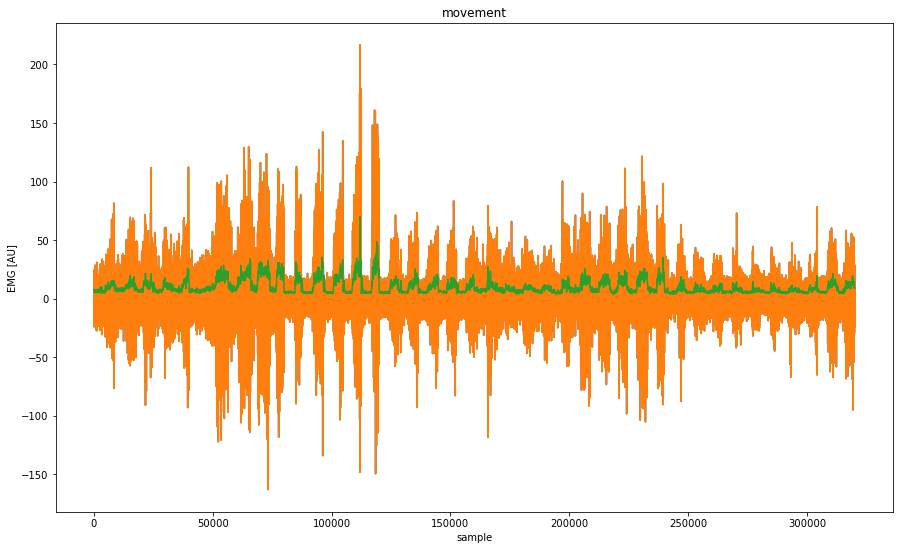

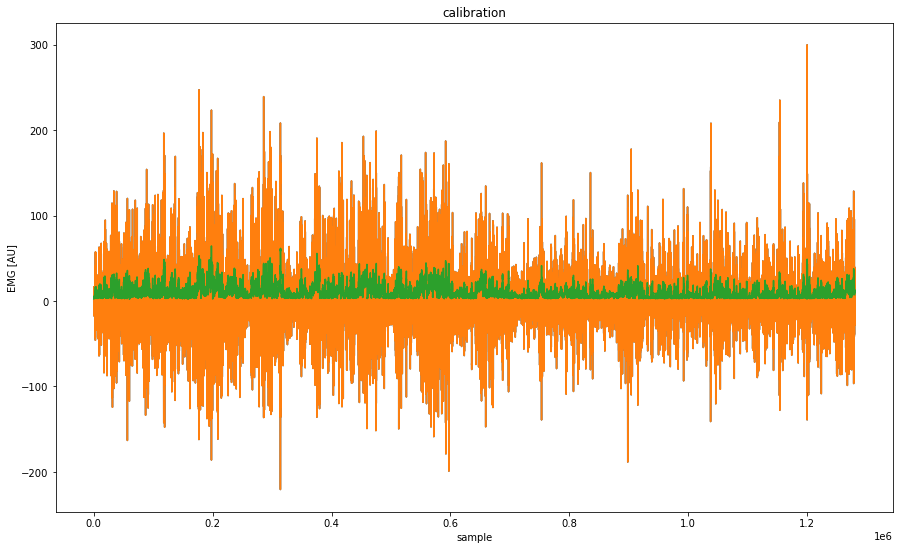

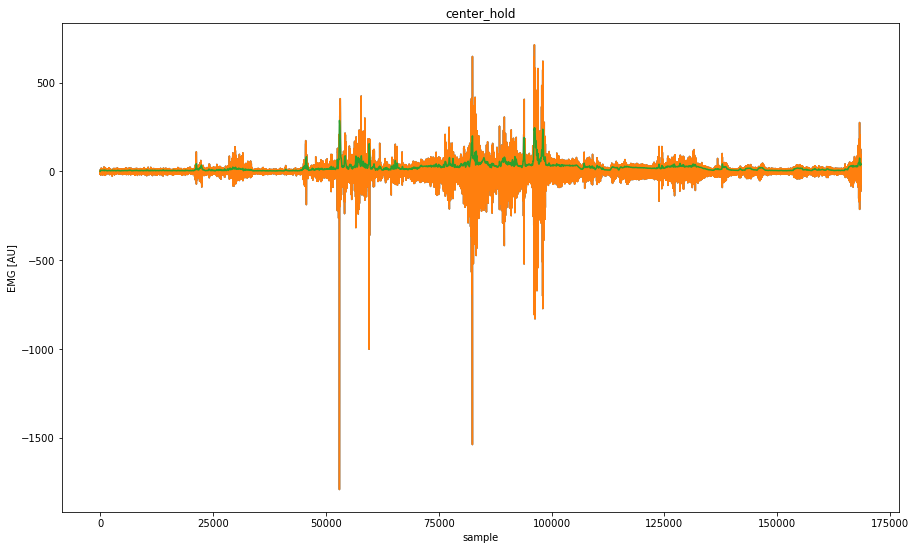

In [21]:
# plot one trial

low_cutoff = 10
start = 0 
stop = -1
channel = 12

if not movement_session is None:
    plt.figure()
    plt.plot(movement_data[start:stop,channel])
    hp = movement_data[start:stop,channel]
    plt.plot(hp)
    lp_rectify = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(lp_rectify)
    plt.title("movement")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

if not calibration_session is None:
    plt.figure()
    plt.plot(calibration_data[start:stop,channel])
    hp = calibration_data[start:stop,channel]
    plt.plot(hp)
    lp_rectify = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(lp_rectify)
    plt.title("calibration")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

if not center_hold_session is None:
    plt.figure()
    plt.plot(center_hold_data[start:stop,channel])
    hp = center_hold_data[start:stop,channel]
    plt.plot(hp)
    lp_rectify = analysis.lowpass(analysis.rectify(hp), cutoff=low_cutoff)
    plt.plot(lp_rectify)
    plt.title("center_hold")
    plt.xlabel("sample")
    plt.ylabel("EMG [AU]")

# inspect mean and var

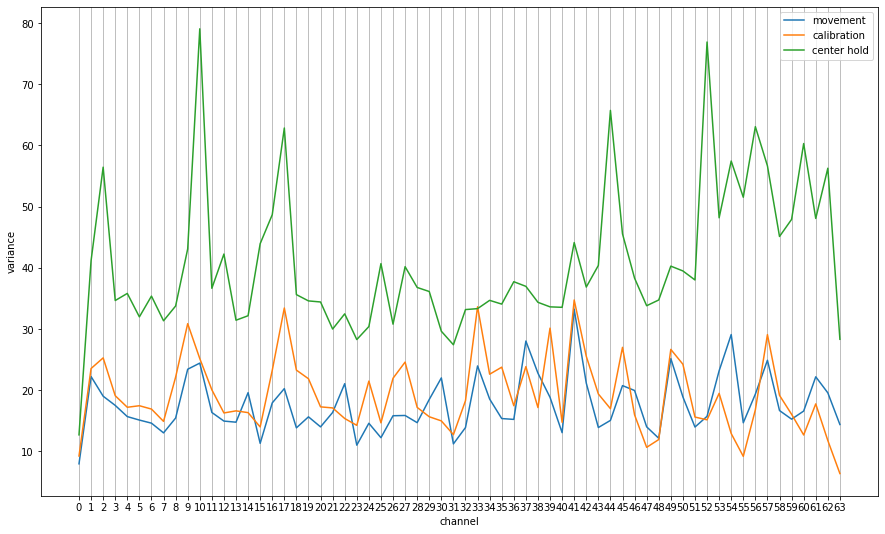

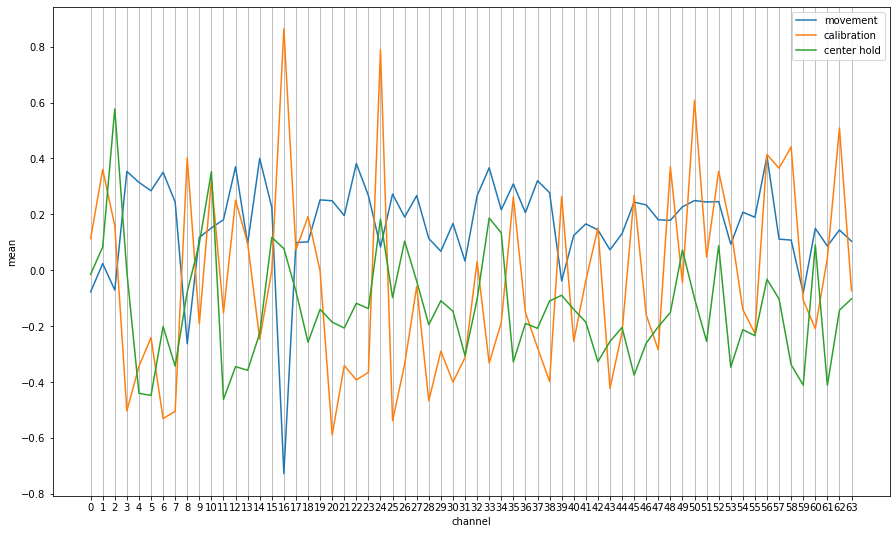

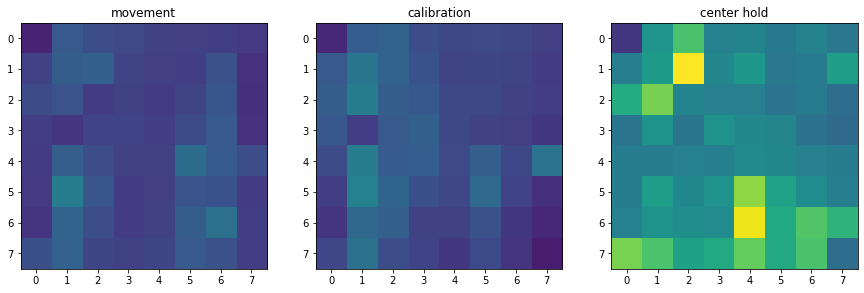

In [41]:
# mean
plt.figure()
if not movement_session is None:
    plt.plot(movement_means, label="movement")
if not calibration_session is None:
    plt.plot(calibration_means, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_means, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("mean")
plt.legend()

# variance
plt.figure()
if not movement_session is None:
    plt.plot(movement_vars, label="movement")
if not calibration_session is None:
    plt.plot(calibration_vars, label="calibration")
if not center_hold_session is None:
    plt.plot(center_hold_vars, label="center hold")
plt.xticks(range(64))
plt.grid(which="both", axis="x")
plt.xlabel("channel")
plt.ylabel("variance")
plt.legend()

maxes = []
if not movement_session is None:
    maxes.append(np.max(movement_vars))
if not calibration_session is None:
    maxes.append(np.max(calibration_vars))
if not center_hold_session is None:
    maxes.append(np.max(center_hold_vars))

maxmax = np.max(maxes)

fig, axes = plt.subplots(1,3)
if not movement_session is None:
    axes[0].imshow(movement_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[0].set_title("movement")
if not calibration_session is None:
    axes[1].imshow(calibration_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[1].set_title("calibration")
if not center_hold_session is None:
    axes[2].imshow(center_hold_vars.reshape(8,8),vmin=0,vmax=maxmax)
    axes[2].set_title("center hold")

# save variance

In [71]:
v = np.diag(np.array(calibration_vars**-1, dtype=np.float32))
print(v)
print(v.shape)

# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment="self_test", subject=subject)
assert subject_metadata_folder.exists()
utils.write_array_to_disk(a=v,path=subject_metadata_folder/"variance.bin")

[[0.10827252 0.         0.         ... 0.         0.         0.        ]
 [0.         0.04249042 0.         ... 0.         0.         0.        ]
 [0.         0.         0.03957029 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.05632947 0.         0.        ]
 [0.         0.         0.         ... 0.         0.08500245 0.        ]
 [0.         0.         0.         ... 0.         0.         0.15708537]]
(64, 64)


# PCA

In [46]:
# scale by movement dataset
standardized_data = np.divide(calibration_data, calibration_vars)
print(standardized_data.shape)

# get components -- channel-wise covariance
num_components = 10
pca_model = PCA(n_components=num_components)
pca_model.fit(standardized_data)
components = pca_model.components_
print(components.shape)

(1279990, 64)
(10, 64)


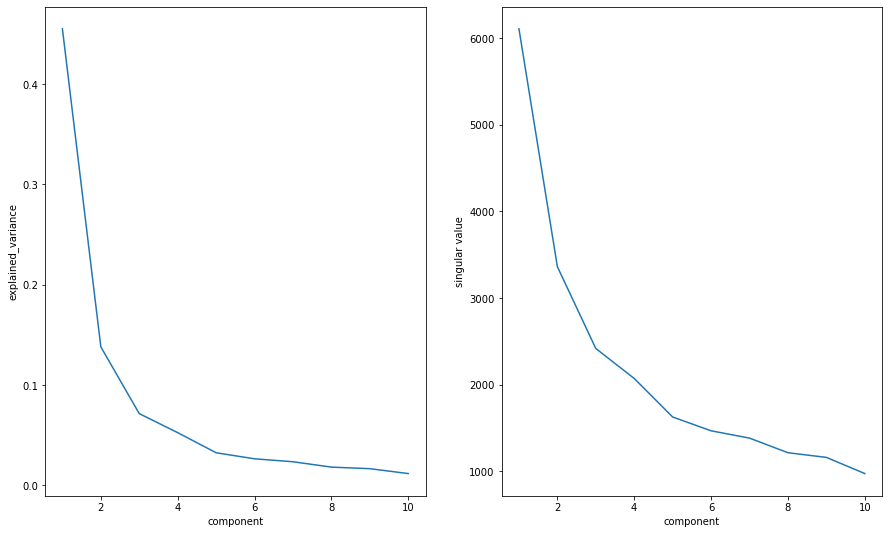

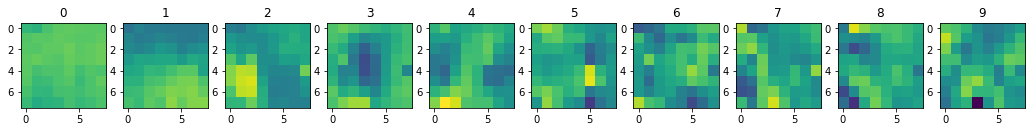

In [49]:
# screeplots
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,num_components+1), pca_model.explained_variance_ratio_)
ax1.set_ylabel("explained_variance")
ax1.set_xlabel("component")

ax2.plot(range(1,num_components+1), pca_model.singular_values_)
ax2.set_ylabel("singular value")
ax2.set_xlabel("component")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(components[i].reshape(8,8),vmin=np.min(components),vmax=np.max(components))
    ax.set_title(str(i))

# negate, normalize, and stack to form decoder
# transform existing data?

In [44]:
print(np.dot(components[0],components[1]))
print(np.dot(components[1],components[1]))
print(np.linalg.norm(components[0]))

-3.122502256758253e-17
0.9999999999999996
1.0000000000000002


# factor analysis

In [31]:
model = FactorAnalysis(n_components=num_components, random_state=0)
model.fit(standardized_data)
factors = model.components_
print(factors.shape)

(10, 64)


In [67]:
print(factors[0].shape)
print(np.dot(factors[0]/np.linalg.norm(factors[0]),
             factors[1]/np.linalg.norm(factors[1])))

(64,)
0.5011840484488218


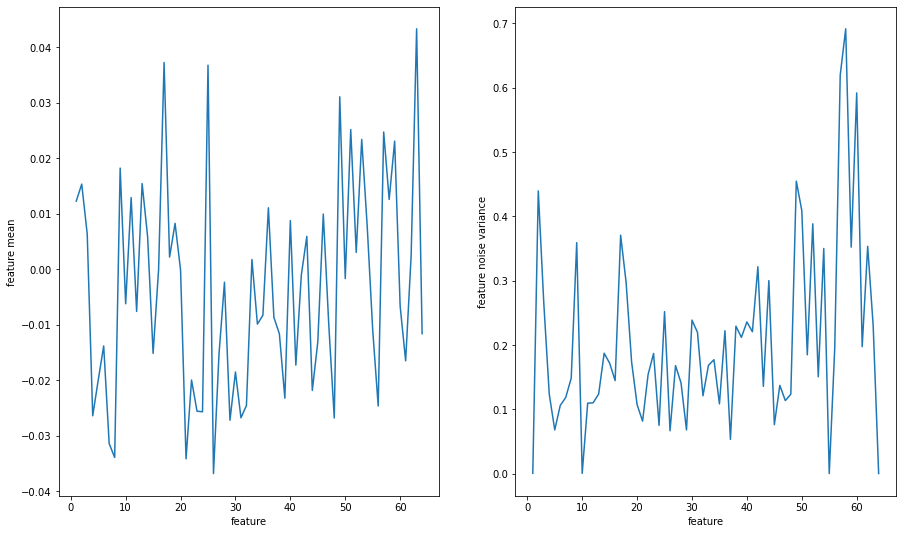

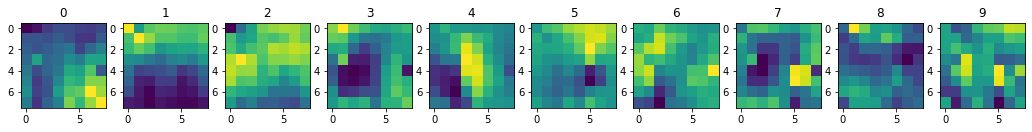

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(1,65), model.mean_)
ax1.set_ylabel("feature mean")
ax1.set_xlabel("feature")

ax2.plot(range(1,65), model.noise_variance_)
ax2.set_ylabel("feature noise variance")
ax2.set_xlabel("feature")

# choose components
fig, axes = plt.subplots(1,num_components,figsize=(18,6))
for i, ax in enumerate(axes):
    ax.imshow(factors[i].reshape(8,8))
    ax.set_title(str(i))

# FastICA!

# save decoder

In [ ]:
# make decoder (up,down,left,right)
idxs = range(1,5)
decoder = np.array(components[idxs],dtype=np.float32)
print(decoder.shape)
print(decoder.dtype)

# convert to 2D (subtract up-down, left-right)
convert_to_2d = np.array([[1,-1,0,0],[0,0,-1,1]])
two_dim_decoder = np.dot(convert_to_2d, decoder)
print(two_dim_decoder.shape)

In [ ]:
# save decoder
subject_metadata_folder = utils.get_subject_folder(experiment="self_test", subject=subject)
assert subject_metadata_folder.exists()
utils.write_array_to_disk(a=decoder,path=subject_metadata_folder/"decoder.bin")

# check decoder

In [ ]:
reload_decoder = utils.load_array_from_disk(subject_metadata_folder/"decoder.bin").reshape(-1,64)
print(reload_decoder.shape)

fig, axes = plt.subplots(1,4)
for i, ax in enumerate(axes):
    ax.imshow(reload_decoder[i].reshape(8,8),vmin=0,vmax=np.max(reload_decoder))

In [ ]:
plt.figure()
trial = center_hold_data[20000:30000]
s_trial = np.divide(trial, calibration_vars)
projection = np.dot(decoder, s_trial.T)

fig, axes = plt.subplots(3,1)
for direction in projection:
    axes[0].plot(direction)
    r = analysis.rectify(direction)
    axes[1].plot(r)
    lp = analysis.lowpass(r, cutoff=10)
    axes[2].plot(lp)